## 时间序列——预测雅虎的每日调整的收盘价

![](./images/data_dictionary.png)

### 初始化下列软件包

In [10]:
%matplotlib inline

import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
from IPython.display import Image
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima_model import ARMA, ARIMA
from sklearn.metrics import explained_variance_score

import mpl_finance as mpf
import pandas_datareader as pdr
# https://blog.csdn.net/Acegem/article/details/102973851

rcParams['figure.figsize'] = 15, 5

In [23]:
# 获取数据
yahoo_data= pdr.get_data_yahoo('INTC', '2016/1/1', '2016/12/31')

In [24]:
yahoo_data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-12-31,34.959999,34.439999,34.820000,34.450001,14736700.0,30.116772
2016-01-04,34.009998,33.459999,33.880001,33.990002,27882200.0,29.714636
2016-01-05,34.000000,33.529999,33.959999,33.830002,16709500.0,29.574759
2016-01-06,33.520000,32.799999,33.250000,33.080002,25491300.0,28.919096
2016-01-07,33.009998,31.840000,32.279999,31.840000,37680500.0,27.835068
...,...,...,...,...,...,...
2016-12-23,36.980000,36.770000,36.930000,36.970001,6287300.0,33.386059
2016-12-27,37.330002,36.910000,36.910000,37.070000,9033700.0,33.476360
2016-12-28,37.200001,36.580002,37.099998,36.630001,12868600.0,33.079010


Text(0.5, 1.0, 'Yahoo Adjusted Closing rate - Year 2016')

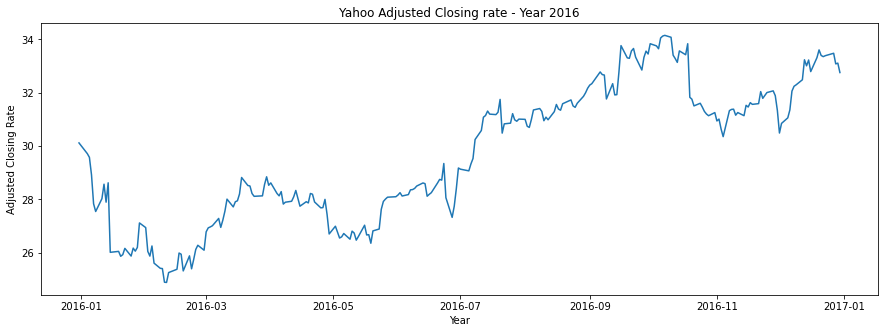

In [42]:
# 划分测试数据和训练数据
# 在2016年的时间序列上绘制调整过的雅虎股票收盘价的图表

data = yahoo_data['Adj Close']

date_thresh = datetime.strptime('2016-10-01', "%Y-%m-%d").date()

data_train = data[:date_thresh]
data_test = data[date_thresh:]

plt.plot(data.index, yahoo_data['Adj Close'])
plt.xlabel('Year')
plt.ylabel('Adjusted Closing Rate')
plt.title('Yahoo Adjusted Closing rate - Year 2016')

## 评估时间序列对象的平稳性
 因为大多数时间序列模型都是为了在平稳数据上给出结果而设计的。

### 具有平稳本质的时间序列的性质

时间序列对象如果具有以下属性，则是平稳的：

1. 没有趋势；
2. 平均数保持不变；
3. 随着时间的推移，方差保持不变；
4. 不存在自相关。自相关是当前时间序列与滞后时间序列之间的相关性。

### 测试以确定时间序列是否平稳

#### 探索性数据分析

**滚动均值**和**滚动方差**。如果这些滚动指标在一段时间内保持不变，分布将被视为平稳的时间序列对象。

![](./images/rolling_mean.png)


#### Dickey-Fuller检验

这更多的是检查时间序列对象是否平稳的统计方法，其无效假设中的测试**假定时间序列对象是非平稳的**。一旦应用到给定的时间序列对象，Dickey-Fuller检验将以不同的置信区间返回测试统计值和临界值。如果测试统计值**低于**临界值，那么无效假设**不成立**，我们**选择备择假设**（即时间序列对象是**平稳的**）。

In [55]:
# 评估时间序列对象是否平稳

def evaluate_stationarity(timeseries, t=30):
    
    # Determing rolling statistics
    rolmean = timeseries.rolling(window=t).mean()
    rolstd = timeseries.rolling(window=t).std()
    
    # Plot rolling statistics
    orig = plt.plot(timeseries, color = 'blue', label='Original')
    mean = plt.plot(rolmean, color = 'red', label='Rolling mean')
    std = plt.plot(rolstd, color = 'black', label='Rolling std')
    
    plt.legend(loc='best')
    plt.title('Rolling mean & Standard Deviation')
    plt.show(block=False)
    
    # Perform Dickey-Fuller test
    print('Dickey-Fuller检验结果')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['测试统计', 'p-value', '#使用延迟', '使用的观察次数'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value/临界值 (%s)' % key] = value
    print(dfoutput)

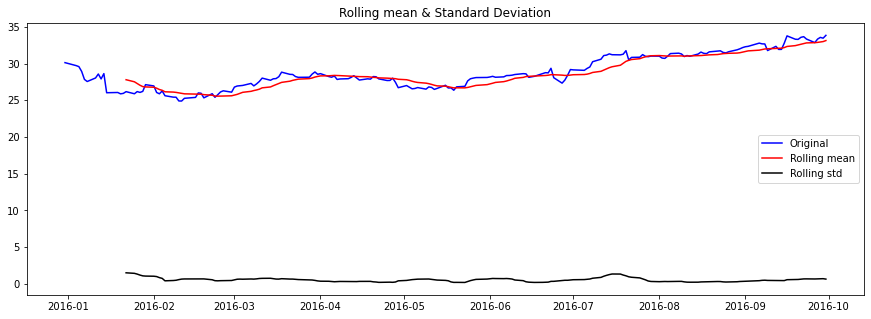

Dickey-Fuller检验结果
测试统计                         -0.370976
p-value                       0.914833
#使用延迟                         0.000000
使用的观察次数                     189.000000
Critical Value/临界值 (1%)      -3.465431
Critical Value/临界值 (5%)      -2.876957
Critical Value/临界值 (10%)     -2.574988
dtype: float64


In [59]:
evaluate_stationarity(data_train,t=15)

从上图中的分析中，尽管滚动标准差的变化很小，但滚动均值似乎相对变化很大。因此，时间序列对象是非平稳的。然后看Dickey-Fuller检验结果，测试统计值大于临界值，因此没有拒绝无效假设，这意味着数据在本质上是非平稳的。

### 使时间序列对象接近平稳

**方法**：

1. 应用转换
2. 估计趋势并将其从原始序列中删除
3. 差分
4. 分解

**1.应用转换**
诸如对数、立方根、平方根等转换会对较大的值进行惩罚，从而可以使其变得平稳。

**1.1对数变换**

未能使时间序列平稳

**1.2平方根变换**

未能使时间序列平稳

**1.3立方变换**

未能使时间序列平稳

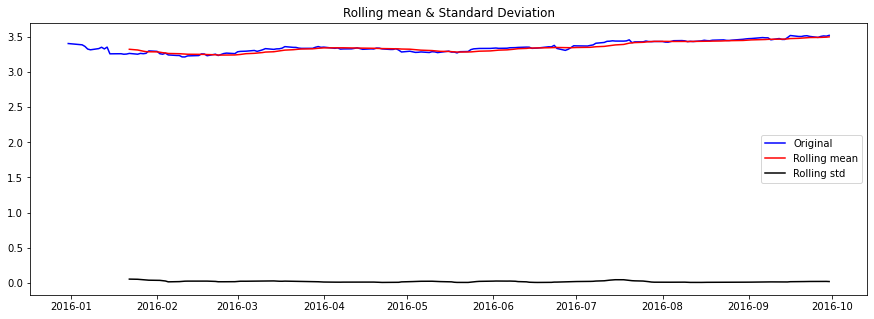

Dickey-Fuller检验结果
测试统计                         -0.529414
p-value                       0.886148
#使用延迟                         0.000000
使用的观察次数                     189.000000
Critical Value/临界值 (1%)      -3.465431
Critical Value/临界值 (5%)      -2.876957
Critical Value/临界值 (10%)     -2.574988
dtype: float64


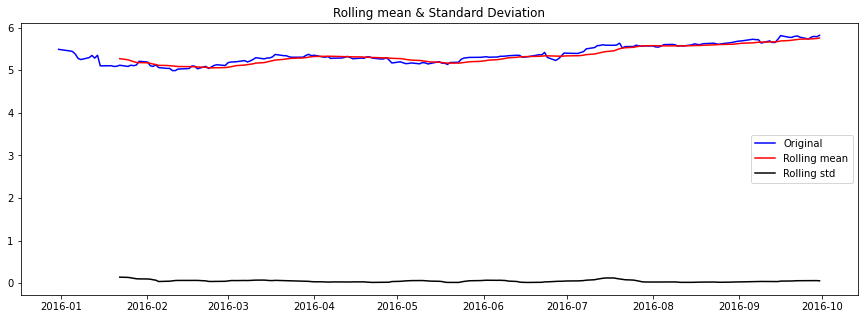

Dickey-Fuller检验结果
测试统计                         -0.450481
p-value                       0.901323
#使用延迟                         0.000000
使用的观察次数                     189.000000
Critical Value/临界值 (1%)      -3.465431
Critical Value/临界值 (5%)      -2.876957
Critical Value/临界值 (10%)     -2.574988
dtype: float64


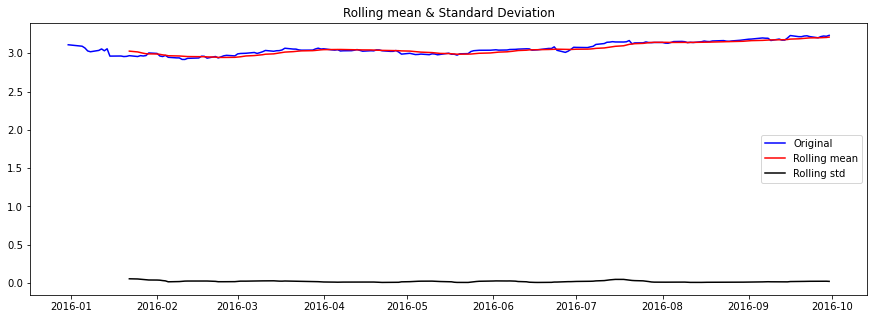

Dickey-Fuller检验结果
测试统计                         -0.476872
p-value                       0.896451
#使用延迟                         0.000000
使用的观察次数                     189.000000
Critical Value/临界值 (1%)      -3.465431
Critical Value/临界值 (5%)      -2.876957
Critical Value/临界值 (10%)     -2.574988
dtype: float64


In [63]:
# 1.1对数变换
evaluate_stationarity(np.log(data_train), 15)

# 1.2平方根变换
evaluate_stationarity(np.sqrt(data_train), 15)

# 1.3立方变换
evaluate_stationarity(np.cbrt(data_train), 15)

**估计趋势并将其从原始序列中删除**

估计趋势+删除趋势

**1.移动平均平滑**

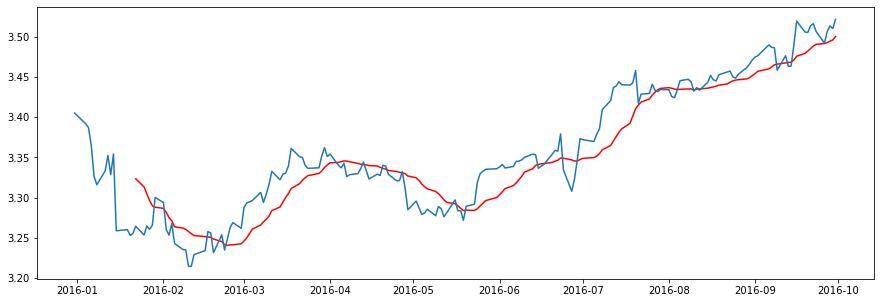

In [72]:
# 将移动平均平滑应用到时间序列对象
data_log = np.log(data_train)
moving_avg = data_log.rolling(15).mean()
plt.plot(moving_avg, 'red')
plt.plot(data_log)

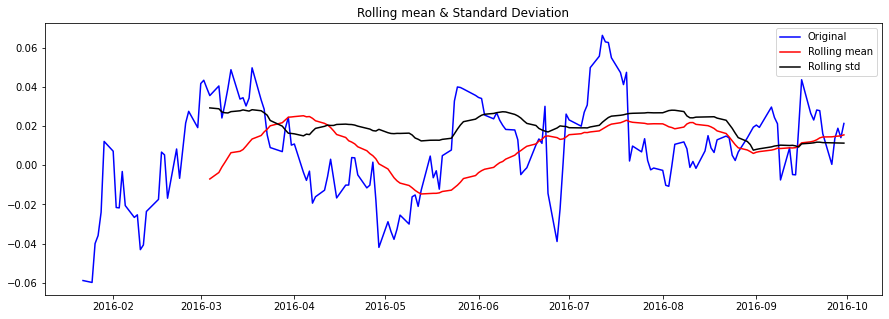

Dickey-Fuller检验结果
测试统计                         -4.031512
p-value                       0.001254
#使用延迟                         0.000000
使用的观察次数                     175.000000
Critical Value/临界值 (1%)      -3.468280
Critical Value/临界值 (5%)      -2.878202
Critical Value/临界值 (10%)     -2.575653
dtype: float64


In [77]:
# 打印无趋势时间序列对象

data_log_moving_avg_diff = data_log - moving_avg
data_log_moving_avg_diff.dropna(inplace=True)
evaluate_stationarity(data_log_moving_avg_diff)

**2.指数加权移动平均平滑**

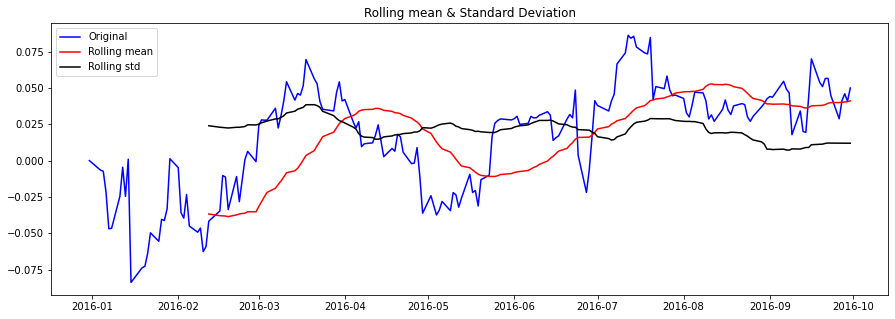

Dickey-Fuller检验结果
测试统计                         -2.633377
p-value                       0.086293
#使用延迟                         0.000000
使用的观察次数                     189.000000
Critical Value/临界值 (1%)      -3.465431
Critical Value/临界值 (5%)      -2.876957
Critical Value/临界值 (10%)     -2.574988
dtype: float64


In [87]:
expwighted_avg = data_log.ewm(halflife=15).mean()
data_log_ewma_diff = data_log - expwighted_avg
evaluate_stationarity(data_log_ewma_diff)

### 差分

**差分**从自身的滞后版本中减去时间序列（即在前一时刻的观察）。差分通过消除等级中的变化来稳定时间序列的均值。**减少趋势和周期性**

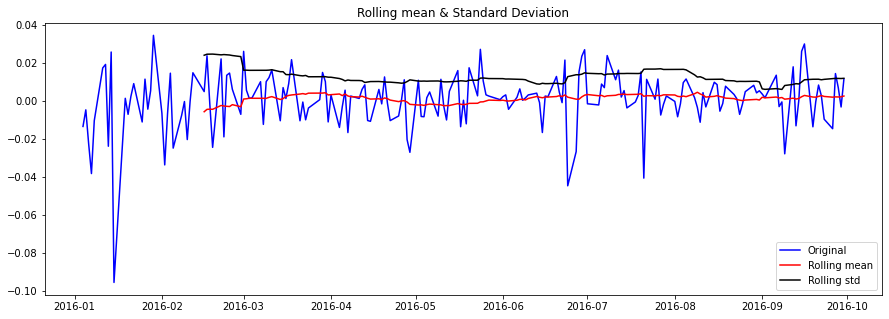

Dickey-Fuller检验结果
测试统计                       -1.010621e+01
p-value                     1.028338e-17
#使用延迟                       1.000000e+00
使用的观察次数                     1.870000e+02
Critical Value/临界值 (1%)    -3.465812e+00
Critical Value/临界值 (5%)    -2.877123e+00
Critical Value/临界值 (10%)   -2.575077e+00
dtype: float64


In [94]:
# 一阶差分

data_log_diff = data_log - data_log.shift()
data_log_diff.dropna(inplace=True)
evaluate_stationarity(data_log_diff)

### 分解

**分解**是另一种从时间序列中消除趋势和周期性的方法，以使其保持平稳性。他通过将时间序列分成三个部分来实现这个目的：**趋势、周期性和残差**。残差（即没有趋势和周期性的时间序列）

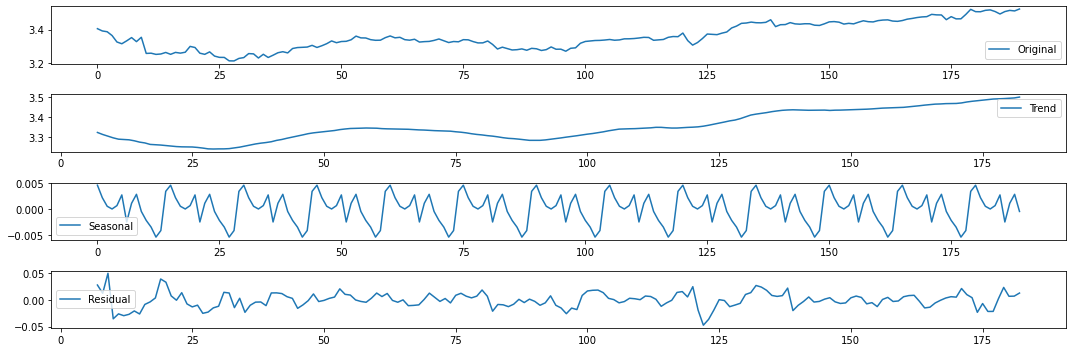

In [102]:
# 分解对数变换后的时间序列

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(list(data_log), period=15)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(list(data_log), label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='best')
plt.tight_layout()

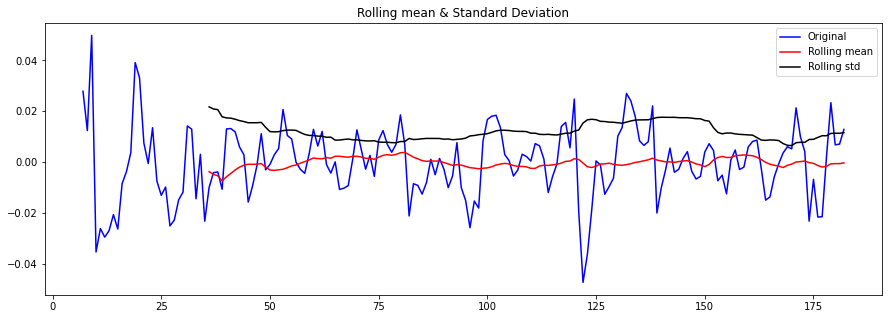

Dickey-Fuller检验结果
测试统计                       -7.898127e+00
p-value                     4.256263e-12
#使用延迟                       2.000000e+00
使用的观察次数                     1.730000e+02
Critical Value/临界值 (1%)    -3.468726e+00
Critical Value/临界值 (5%)    -2.878396e+00
Critical Value/临界值 (10%)   -2.575756e+00
dtype: float64


In [103]:
data_log_decompose = pd.Series(residual)
data_log_decompose.dropna(inplace=True)
evaluate_stationarity(data_log_decompose)

## 测试以确定时间序列是否具有自相关性

### 自相关函数

**自相关函数（ACF）**决定时间序列及其滞后时间序列的相关性。例如，具有10个观察值的数据和滞后为5的数据，将具有以下计算序列之间的相关性：
![](./images/acf.png)

### 偏自相关函数

偏自相关函数（PACF）也用来度量时间序列与滞后时间序列的相关性。例如在我们的示例中，滞后为5，它将消除$t_0$和$t_3$之间已经捕捉到的变化。

### Durbin Watson 统计

与自相关相关图**相反**，Durban Watson统计更多的是确定数据内**自相关存在性**的统计方法。他是通过计算**残差**之间的自相关来实现的，而这些残差是从统计回归分析中得到的。他返回**一个介于0和4之间的数字，其中0表示强自相关，4表示强负自相关，2表示无自相关**。

差分可以用来根除ACF和PACF。

In [106]:
# 计算对数变换差分后的时间序列的Durban Watson统计
# 结果接近2，表明在对数变换差分后的时间序列中不存在自相关
sm.stats.durbin_watson(data_log_diff)

2.138466241426992

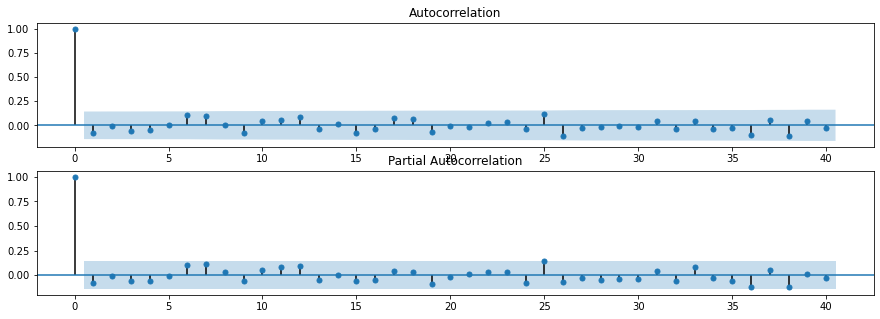

In [107]:
# 对于对数变换差分后的时间序列
# 绘制ACF和PACF的自相关图

ax1 = plt.subplot(211)
fig = sm.graphics.tsa.plot_acf(data_log_diff.squeeze(), lags=40, ax=ax1)
ax2 = plt.subplot(212)
fig = sm.graphics.tsa.plot_pacf(data_log_diff, lags=40, ax=ax2)

## 建模时间序列

**给定时间序列模型的参数如下：p，d，q。**

- 自回归数（AR）项或p：AR项是响应变量的滞后，例如p=5。因此，为了预测$t_5$的响应变量，$t_0$和$t_4$之间的时间序列被视为探索变量。
- 移动平均数（MA）项目或q。
- 差分数（d）：这是我们关注的用于时间序列对象的差分顺序。

### 验证预测序列的实验（评价指标/评估标准）

#### 1. 平均预测误差

这是每个时间点的残差平均数，平均预测误差值可以从**负无穷到正无穷**。

#### 2. 平均绝对误差
平均绝对误差与平均预测误差相同，只是残差被转换为绝对值。值可以从**0到正无穷**。

#### 3. 残差平方和
残差平方和（RSS）通常用于回归分析。

#### 4.均方根误差
均方根误差（RMSE）也被称为均方根偏差（RMSD），是RSS的一个高级版本。

### 确定建模参数（p，q，d）

#### 1. 规则1：p=1。当ACF显示指数衰减时，并且PACF在滞后1时有一个峰值，没有进一步的相关性。
![](./images/p_1.png)    
#### 2. 规则2：p=2。当ACF显示一组指数衰减或正弦波形模式时，并且PACF在滞后1和2时有峰值，没有进一步的相关性。
![](./images/p_2.png)
#### 3. 规则3：q=1。当ACF在滞后1时有一个峰值，没有进一步的相关性，并且PACF显示指数衰减。
![](./images/q_1.png)   
#### 4. 规则4：q=2。当ACF在滞后1和2时有一个峰值，没有进一步的相关性，并且PACF显示出一组指数衰减或正弦波形模式。
![](./images/q_2.png)   
#### 5. 规则5：p=1，q=1。当ACF和PACF在滞后1时都显示指数衰减。
![](./images/p_1andq_1.png)   

## 自回归综合移动平均（ARIMA）

ARIMA代表自回归综合移动平均，ARIMA预测围绕一个线性方程进行，此线性方程的行为取决于p、d和q的值。换句话说，**ARIMA模型可以过滤来自噪声的信号并预测未来的时间点**。ARIMA模型定义为**ARIMA（p,d,q）**。

### 自回归移动平均

ARMA（自回归移动平均）模型与ARIMA模型相似，只是现在我们使用p和q来确定线性方程。而且，**此时的预测是在一个平均调整序列上完成的；也就是说，时间序列通过从中减去样本均值被转换为零均值变体**。**ARMA（p，q）**

![](./images/ARMA_1.png)
![](./images/ARMA_2.png)

### 自回归

AR（自回归）模型根据其过去值的线性函数来预测时间序列。在AR模型中定义时间滞后以预测时间序列的未来值。**AR模型被定义为AR（p，q）**。
![](./images/AR.png)

- $\beta_0$和$\beta_1$：Beta系数；
- $y_{t-1}$:时间序列的滞后版本；
- $\epsilon_t$：残差，假设他们是正态分布的且在时间上是随机的。

/home/wbb/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Text(0.5, 1.0, 'RSS:0.0411')

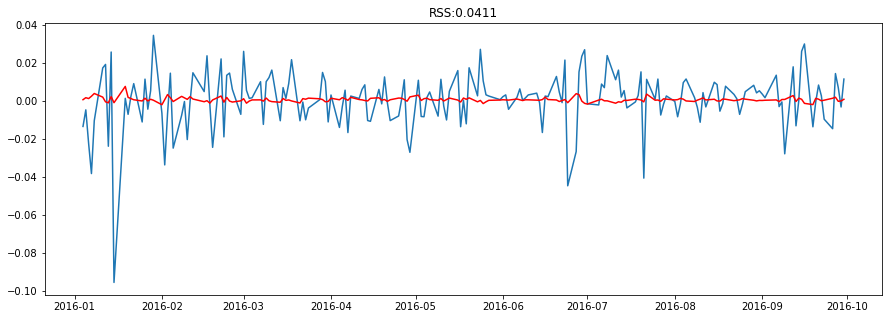

In [143]:
# p=2,d=1,q=0

model = ARIMA(data_log, order=(2,1,0))
results_AR_210 = model.fit(disp=-1)
plt.plot(data_log_diff)
plt.plot(results_AR_210.fittedvalues, color='red')
plt.title('RSS:%.4f' % sum((results_AR_210.fittedvalues-data_log_diff)**2))

### 移动平均线

MA（移动平均线）代表移动平均模型。MA适用于有单变量时间序列对象的情况。MA通过训练本身为随机性时间序列的当前值和过去值来预测未来值。**MA模型被定义为MA（d，q）。**

/home/wbb/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Text(0.5, 1.0, 'RSS:0.0411')

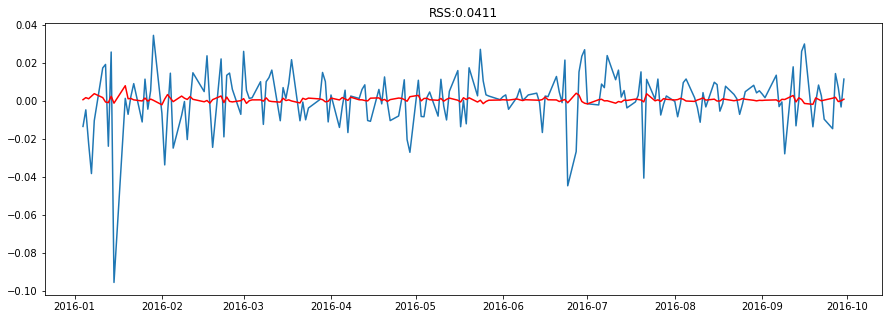

In [144]:
# p=0,d=1,q=1

model = ARIMA(data_log, order=(0,1,1))
results_MA_011 = model.fit(disp=-1)
plt.plot(data_log_diff)
plt.plot(results_MA_011.fittedvalues, color='red')
plt.title('RSS:%.4f' % sum((results_MA_011.fittedvalues-data_log_diff)**2))

### 组合模型（AR和MA）

/home/wbb/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Text(0.5, 1.0, 'RSS:0.0412')

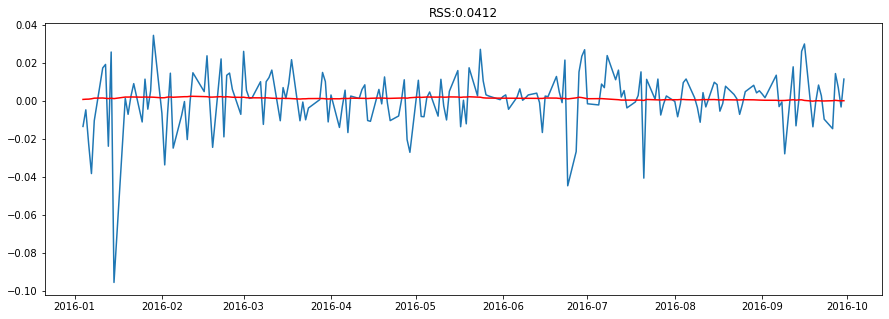

In [145]:
#  p=1,d=1,q=1

model = ARIMA(data_log, order=(1,1,1))
results_ARIMA_111 = model.fit(disp=-1)
plt.plot(data_log_diff)
plt.plot(results_ARIMA_111.fittedvalues, color='red')
plt.title('RSS:%.4f' % sum((results_ARIMA_111.fittedvalues-data_log_diff)**2))

## 缩减预测规模

在将预测缩减到原始单位之前，打印被预测时间序列的初始观察值。

In [147]:
prediction_ARIMA_diff = pd.Series(results_ARIMA_111.fittedvalues, copy=True)
print(prediction_ARIMA_diff.head(10))

Date
2016-01-04    0.000757
2016-01-05    0.000871
2016-01-06    0.000914
2016-01-07    0.001101
2016-01-08    0.001417
2016-01-11    0.001504
2016-01-12    0.001361
2016-01-13    0.001203
2016-01-14    0.001407
2016-01-15    0.001190
dtype: float64


这些模型的输出在每个时间间隔都给出了**绝对变化**而不是**累计和**。如果数据是离散的，那么绝对变化将是一个合理的策略。然而，在预测序列连续分布的情况下，就要使用累计和这种方式了。

In [148]:
prediction_ARIMA_diff_cumsum = prediction_ARIMA_diff.cumsum()
print(prediction_ARIMA_diff_cumsum.head(10))

Date
2016-01-04    0.000757
2016-01-05    0.001628
2016-01-06    0.002542
2016-01-07    0.003643
2016-01-08    0.005060
2016-01-11    0.006564
2016-01-12    0.007926
2016-01-13    0.009128
2016-01-14    0.010535
2016-01-15    0.011725
dtype: float64


In [149]:
# 利用Akaike信息准则（AIC）来测试时间序列模型的质量时；
# AIC得分越低，时间序列模型的质量越好。

print(results_ARIMA_111.aic)

-1049.0658681624063


上面输出的得分非常低，从而证明了模型的优势。现在通过**反转差分**和**对数变换**来预测规模。

- 从预测序列中移除差分；
- 通过应用指数来反转对数变换；
- 通过计算平均预测误差、平均绝对误差和均方根绝对误差来评估预测的序列；
- 绘制原始和预测的序列图

In [177]:
# 打印消除差分的预测时间序列

predictions_ARIMA_log = data_log
predictions_ARIMA_log = predictions_ARIMA_log.add(prediction_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head(10)

Date
2015-12-31    3.405082
2016-01-04    3.392397
2016-01-05    3.388549
2016-01-06    3.367044
2016-01-07    3.329939
2016-01-08    3.320938
2016-01-11    3.339747
2016-01-12    3.360262
2016-01-13    3.337621
2016-01-14    3.364705
dtype: float64

Text(0.5, 1.0, 'RMSE: 5.3624 | MFE: -4.6212 | MAE: 0.1410')

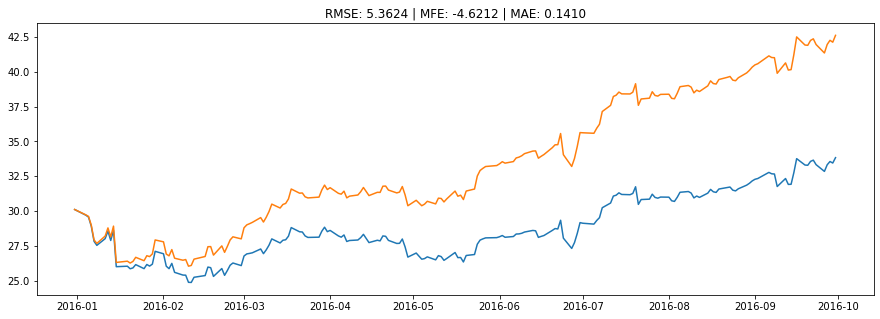

In [180]:
# 评估预测序列和原始序列

def mean_forecast_err(y, yhat):
    return y.sub(yhat).mean()
def mean_absolute_err(y, yhat):
    return np.mean((np.abs(y.sub(yhat).mean()) / yhat))
def rmse(y, yhat):
    return np.sqrt(sum((yhat-y)**2)/len(y))
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(data_train)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f | MFE: %.4f | MAE: %.4f'% (rmse(data_train, predictions_ARIMA), mean_forecast_err(data_train, predictions_ARIMA), mean_absolute_err(data_train, predictions_ARIMA)))

In [170]:
predictions_ARIMA

Date
2015-12-31    30.116772
2016-01-04    29.737138
2016-01-05    29.622934
2016-01-06    28.992687
2016-01-07    27.936642
                ...    
2016-09-26    41.338455
2016-09-27    41.948248
2016-09-28    42.246400
2016-09-29    42.112525
2016-09-30    42.601559
Length: 190, dtype: float64

In [174]:
data_train

Date
2015-12-31    30.116772
2016-01-04    29.714636
2016-01-05    29.574759
2016-01-06    28.919096
2016-01-07    27.835068
                ...    
2016-09-26    32.848370
2016-09-27    33.323391
2016-09-28    33.556423
2016-09-29    33.448868
2016-09-30    33.834267
Name: Adj Close, Length: 190, dtype: float64

## 时间序列分析应用

1. 销售预测；
2. 天气预测；温度、降雨量、湿度、风速等；
3. 失业率估计；
4. 疾病爆发;
5. 股市预测.